In [1]:

# !pip install gensim
# !pip install python-Levenshtein



import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# import nltk
# nltk.download('stopwords')
# from nltk.corpus import stopwords
from tqdm import tqdm
import re
import collections
# from wordcloud import STOPWORDS
# from scipy.sparse import csr_matrix
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
# nltk.download('vader_lexicon')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
# import string
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from wordcloud import WordCloud
import gensim
import time
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import multiprocessing
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression



# Run the next cell only if you want to train the model. 
# If already trained, Skip to the next cell and directly load the model.

In [2]:
train_data = pd.read_csv("preprocessed_tokenized_training_data.csv")
train_data['concatenated_description'] = train_data['concatenated_description'].map(str)
train_data_idf = train_data.copy()

In [3]:
train_data

,Unnamed: 0,train_id,item_condition_id,price,shipping,concatenated_description
0,0,0,3,10.0,1,mlb cincinnati reds shirt size xl Not known de...
1,1,1,3,52.0,0,razer blackwidow chroma keyboard Razer keyboar...
2,2,2,1,10.0,1,avaviv blouse Target adorable top hint lace ke...
3,3,3,1,35.0,1,leather horse statues Not known new tags leath...
4,4,4,1,44.0,0,24k gold plated rose Not known complete certif...
...,...,...,...,...,...,...
1481656,1481656,1482530,2,20.0,1,free people inspired dress Free People lace sa...
1481657,1481657,1482531,2,14.0,0,little mermaid handmade dress Disney little me...
1481658,1481658,1482532,2,12.0,0,21 day fix containers eating plan Not known us...
1481659,1481659,1482533,3,45.0,1,world markets lanterns Not known 2 one see 2 r...


In [3]:
train_data['concatenated_description'] = train_data['concatenated_description'].apply(gensim.utils.simple_preprocess)

In [4]:
cores = multiprocessing.cpu_count()

# Build the Word2Vec model
# Continous bag of words
# Train the Word2Vec model

model2 = Word2Vec(vector_size=200, window=5, min_count=1, sg=0, workers=cores-1)
model2.build_vocab(train_data['concatenated_description'], progress_per=1000)
t = time.time()
model2.train(train_data['concatenated_description'], total_examples=model2.corpus_count, epochs=20)
print('Time to build vocab for Model-2: {} mins'.format(round((time.time() - t) / 60, 2)))


Time to build vocab for Model-2: 18.39 mins


In [5]:
model2.save("word2vec_cbow_model")

# One can directly load the model from here instead of training the models again.

In [ ]:
#Loading a pretrained model

model2 = Word2Vec.load("word2vec_cbow_model")


In [6]:
def avg_word2vec2(doc):
    return np.mean([model2.wv[word] for word in doc if word in model2.wv.index_to_key], axis=0)

In [8]:
train_data_model2 = train_data.copy()

series = train_data_model2.concatenated_description.apply(avg_word2vec2)

df = pd.DataFrame(series.apply(pd.Series))

train_data_model2 = pd.concat([train_data_model2, df], axis=1)

train_data_model2 = train_data_model2.drop(['concatenated_description'],axis=1)

In [ ]:
train_data_model2.to_csv('avgword2vec_cbow.csv')

In [4]:
train_data_model2 = pd.read_csv('avgword2vec_cbow.csv')

In [5]:
train_data_model2.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'train_id', 'item_condition_id', 'price',
       'shipping', '0', '1', '2', '3',
       ...
       '190', '191', '192', '193', '194', '195', '196', '197', '198', '199'],
      dtype='object', length=206)

In [6]:
train_data_model2.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'train_id'], inplace=True)

In [7]:
train_data_model2

,item_condition_id,price,shipping,0,1,2,3,4,5,6,...,190,191,192,193,194,195,196,197,198,199
0,2,8.0,1,-0.100559,-0.614330,0.208602,0.571966,-0.131203,0.016526,0.608419,...,-0.075749,0.193744,0.494159,-0.073508,0.494414,-0.169989,0.131777,0.145828,0.024475,-0.127633
1,3,14.0,0,-0.329170,-0.350506,0.272558,0.105843,1.208020,1.528792,-0.091454,...,-1.339325,0.835479,0.271060,0.437964,1.127263,1.099126,-0.569234,-0.982572,-0.126194,-0.116404
2,1,25.0,1,-0.240003,-0.041858,0.145329,0.452647,0.760089,0.097341,0.452785,...,0.418078,0.219362,0.174552,-0.024960,-0.002166,0.013162,-0.374551,-0.620355,0.631266,-0.212377
3,3,25.0,0,-0.101531,-0.345377,-0.117154,-0.361317,-0.764579,0.917608,0.777097,...,-0.010613,0.054686,0.057820,1.474908,0.728149,1.006546,-0.213868,0.185430,-0.457993,-0.727977
4,1,12.0,1,0.820777,-0.600387,-0.174789,-0.790316,0.611780,0.271854,0.250769,...,-0.093859,0.078621,-0.048399,-0.540433,0.852686,0.234550,-0.283534,-0.156189,0.549295,-0.314060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370407,1,20.0,1,0.484753,0.030433,-0.842793,-0.549632,0.861718,1.395888,1.131525,...,-0.391027,0.211749,-0.072331,1.241811,2.145595,1.513619,1.109203,-1.061759,0.059616,-1.878718
370408,1,44.0,0,-0.989117,-0.492069,-0.002195,0.631189,1.291212,-0.071031,0.779076,...,0.386589,0.272975,-0.883474,-0.305047,-1.207003,0.288548,-1.372537,-0.139790,1.139007,0.010722
370409,3,15.0,1,0.183705,0.060849,0.345536,0.088263,0.149190,0.014507,0.373666,...,-0.325529,0.767687,0.523542,0.516035,0.218952,0.475278,-0.767223,0.097173,-0.474679,-0.750847
370410,1,16.0,0,-0.263113,-0.582247,0.410359,-0.201431,0.439368,1.350481,0.880811,...,-0.339725,0.607348,-0.159939,0.906151,1.756508,0.985768,0.587361,-0.796640,-0.361518,-1.248246


## "avgword2vec_sg.csv" --> Will be used for "train_test_split", Contains 0.03 of entire dataset. 
## Generated from extracting dataset "preprocessed_tokenized_training_data.csv" and then applying "word2vec_cbow_model" on it.

# We've our dataset ready for the Model-2.

In [8]:
data = train_data_model2.copy()

In [9]:
from sklearn.model_selection import train_test_split

y = data['price']
X = data.drop(columns=['price'])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Hyperparameter optimization using RandomizedSearchCV

In [11]:

from sklearn.model_selection import RandomizedSearchCV

In [11]:
# from scipy.stats import reciprocal
model = MLPRegressor()

param_dist = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50, 25)],
    'max_iter' : [500, 1000, 2000],
    'activation': ['relu', 'tanh','logistic'],
    'alpha' : [0.00005, 0.005, 0.0005, 0.0001],
    'solver':['lbfgs','adam'],
    'random_state' : [6, 7, 42],
     'early_stopping' : [True],
     'validation_fraction' : [0.2],
    'learning_rate': ['invscaling','constant', 'adaptive']
}


random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=5, verbose=3)

# Fit the data to perform random search
random_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Make predictions using the best model
y_pred = best_model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END activation=relu, alpha=0.0005, early_stopping=True, hidden_layer_sizes=(50,), learning_rate=invscaling, max_iter=1000, random_state=42, solver=lbfgs, validation_fraction=0.2;, score=0.245 total time= 7.8min
[CV 2/5] END activation=relu, alpha=0.0005, early_stopping=True, hidden_layer_sizes=(50,), learning_rate=invscaling, max_iter=1000, random_state=42, solver=lbfgs, validation_fraction=0.2;, score=0.036 total time= 7.7min
[CV 3/5] END activation=relu, alpha=0.0005, early_stopping=True, hidden_layer_sizes=(50,), learning_rate=invscaling, max_iter=1000, random_state=42, solver=lbfgs, validation_fraction=0.2;, score=0.168 total time= 7.9min
[CV 4/5] END activation=relu, alpha=0.0005, early_stopping=True, hidden_layer_sizes=(50,), learning_rate=invscaling, max_iter=1000, random_state=42, solver=lbfgs, validation_fraction=0.2;, score=-0.183 total time= 7.7min
[CV 5/5] END activation=relu, alpha=0.0005, early_stopping

[CV 3/5] END activation=relu, alpha=5e-05, early_stopping=True, hidden_layer_sizes=(50, 50), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam, validation_fraction=0.2;, score=0.363 total time=  47.8s
[CV 4/5] END activation=relu, alpha=5e-05, early_stopping=True, hidden_layer_sizes=(50, 50), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam, validation_fraction=0.2;, score=0.418 total time=  58.3s
[CV 5/5] END activation=relu, alpha=5e-05, early_stopping=True, hidden_layer_sizes=(50, 50), learning_rate=adaptive, max_iter=500, random_state=42, solver=adam, validation_fraction=0.2;, score=0.369 total time=  56.5s
[CV 1/5] END activation=logistic, alpha=5e-05, early_stopping=True, hidden_layer_sizes=(100,), learning_rate=invscaling, max_iter=1000, random_state=7, solver=lbfgs, validation_fraction=0.2;, score=0.238 total time=29.6min
[CV 2/5] END activation=logistic, alpha=5e-05, early_stopping=True, hidden_layer_sizes=(100,), learning_rate=invscaling, ma

In [12]:
best_model = MLPRegressor(alpha=5e-05, early_stopping=True, hidden_layer_sizes=(50, 50),
             learning_rate='adaptive', max_iter=500, random_state=42,
             validation_fraction=0.2)

# Multi-Layered Perceptron Model

# KPCA Tuning

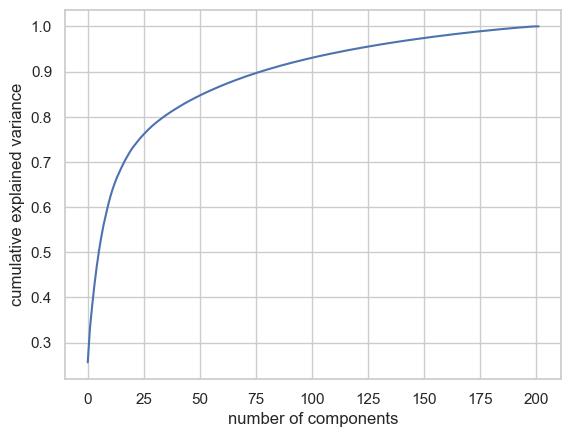

None

In [33]:
from sklearn.decomposition import KernelPCA
kpca_test = KernelPCA()
kpca_test = kpca_test.fit_transform(X_train)
explained_variance = np.var(kpca_test, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)

sns.set(style='whitegrid')
plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
display(plt.show())

evr = explained_variance_ratio
cvr = np.cumsum(explained_variance_ratio)

In [34]:
kpca_df = pd.DataFrame()
kpca_df['Cumulative Variance Ratio'] = cvr
kpca_df['Explained Variance Ratio'] = evr
display(kpca_df[kpca_df['Cumulative Variance Ratio'] >= 0.90])

,Cumulative Variance Ratio,Explained Variance Ratio
78,0.901335,0.001534
79,0.902856,0.001521
80,0.904359,0.001503
81,0.905842,0.001482
82,0.907310,0.001469
...,...,...
197,0.999251,0.000364
198,0.999594,0.000343
199,0.999918,0.000324
200,0.999971,0.000052


### From the above table, we can conclude that even if we use approx. half the number of components using Kernalized PCA, our new dataset will have a Cumulative Variance as 90% of the original dataset

# KPCA Tuned

In [14]:
X_train = X_train[:10000]
y_train = y_train[:10000]
X_test = X_test[:3500]
y_test = y_test[:3500]

In [15]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components=100)
X_train = kpca.fit_transform(X_train)
X_test = kpca.transform(X_test)

In [16]:
X_train.shape

(10000, 100)

In [18]:
best_model.fit(X_train, y_train)

MLPRegressor(alpha=5e-05, early_stopping=True, hidden_layer_sizes=(50, 50),
             learning_rate='adaptive', max_iter=500, random_state=42,
             validation_fraction=0.2)

In [19]:
y_pred = best_model.predict(X_test)

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import numpy as np


# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test,y_pred)
print("Mean Absolute Error (MAE):", mae)

# R-squared (R²) or Coefficient of Determination
r2 = r2_score(y_test, y_pred)
print("R-squared (R²):", r2)

# Explained Variance Score
explained_var = explained_variance_score(y_test, y_pred)
print("Explained Variance Score:", explained_var)

Mean Squared Error (MSE): 955.990888657508
Root Mean Squared Error (RMSE): 30.91910232619162
Mean Absolute Error (MAE): 15.398330761501565
R-squared (R²): 0.21709931925488557
Explained Variance Score: 0.21829851443570392


In [24]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score

# Create an MLPRegressor model with desired hyperparameters
model = best_model

# Define the input features X and the target variable y

# Perform cross-validation with 5 folds
num_folds = 5
scores = cross_val_score(model, X, y, cv=num_folds, scoring='neg_mean_squared_error')

# Cross-validation returns negative mean squared error, so we take the absolute values
mse_scores = -scores

# Compute the mean and standard deviation of the cross-validation scores
mean_mse = mse_scores.mean()
std_mse = mse_scores.std()
# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_mse)
# Print the results
print("Mean MSE:", mean_mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Standard Deviation of MSE:", std_mse)

Mean MSE: 888.2761262506817
Root Mean Squared Error (RMSE): 29.803961586518692
Standard Deviation of MSE: 44.816917641833285


In [23]:
pd.DataFrame(y_pred).to_csv('Prediction_Model3.csv')

In [25]:
y_pred_model1 = pd.read_csv('Prediction_Model1.csv')
y_pred_model2 = pd.read_csv('Prediction_Model2.csv')
y_pred_model3 = pd.read_csv('Prediction_Model3.csv')

In [29]:
y_pred_model1 = y_pred_model1[:3500]

In [30]:
y_pred_model2.shape

(3500, 2)

In [33]:
y_pred_model3

,Unnamed: 0,0
0,0,16.835711
1,1,6.774873
2,2,21.022932
3,3,18.755128
4,4,47.967542
...,...,...
3495,3495,117.268790
3496,3496,23.496749
3497,3497,46.579754
3498,3498,10.976207


In [34]:
import pickle
filename = 'model3.pkl'
with open(filename, 'wb') as file:
    pickle.dump(best_model, file)


In [35]:
import pickle

# Load the MLP model from file
filename = 'model1.pkl'
with open(filename, 'rb') as file:
    model1 = pickle.load(file)


In [36]:
import pickle

# Load the MLP model from file
filename = 'model2.pkl'
with open(filename, 'rb') as file:
    model2 = pickle.load(file)


In [37]:
import pickle

# Load the MLP model from file
filename = 'model3.pkl'
with open(filename, 'rb') as file:
    model3 = pickle.load(file)


In [39]:
y_pred_model2 = model2.predict(X_test)
y_pred_model3 = model3.predict(X_test)


In [40]:
data = train_data_model2.copy()
from sklearn.model_selection import train_test_split

y = data['price']
X = data.drop(columns=['price'])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [41]:
X_test = X_test[:3500]
y_pred_model1 = model1.predict(X_test)


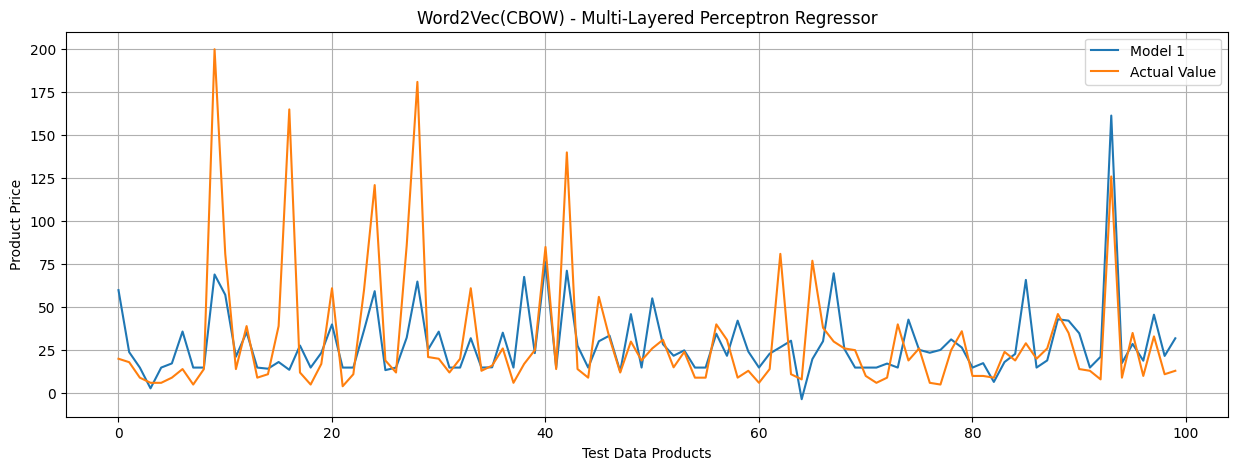

In [61]:
import matplotlib.pyplot as plt




plt.figure(figsize=(15, 5))

plt.grid(True)
x= [i for i in range(100)]
plt.plot(x, y_pred_model1[:100], label='Model 1')
plt.plot(x, y_test[:100], label='Actual Value')

plt.title("Word2Vec(CBOW) - Multi-Layered Perceptron Regressor")
plt.xlabel("Test Data Products")
plt.ylabel("Product Price")
plt.legend()

# Display the plot
plt.show()

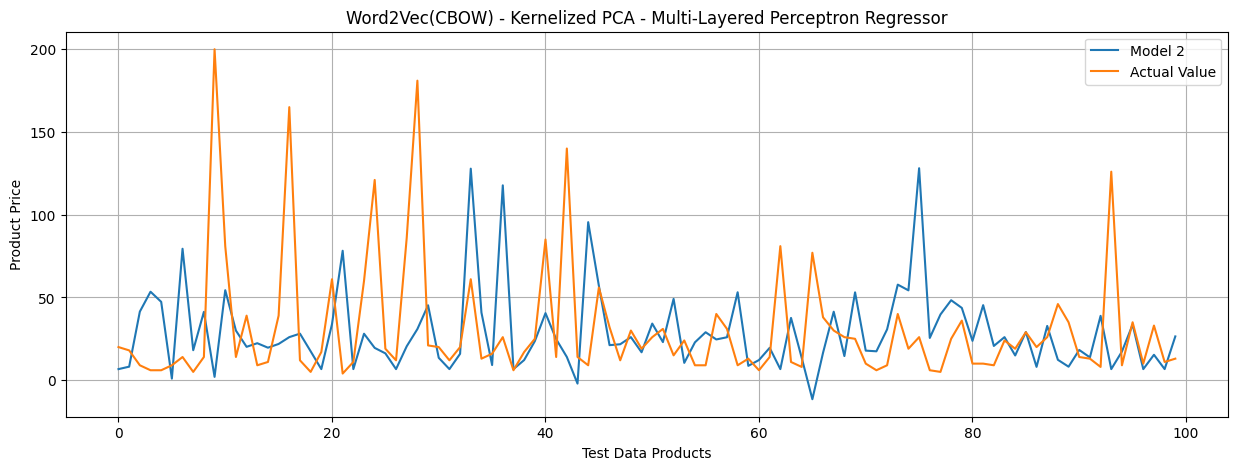

In [60]:
import matplotlib.pyplot as plt




plt.figure(figsize=(15, 5))

plt.grid(True)
x= [i for i in range(100)]
plt.plot(x, y_pred_model2[:100], label='Model 2')
plt.plot(x, y_test[:100], label='Actual Value')

plt.title("Word2Vec(CBOW) - Kernelized PCA - Multi-Layered Perceptron Regressor")
plt.xlabel("Test Data Products")
plt.ylabel("Product Price")
plt.legend()

# Display the plot
plt.show()

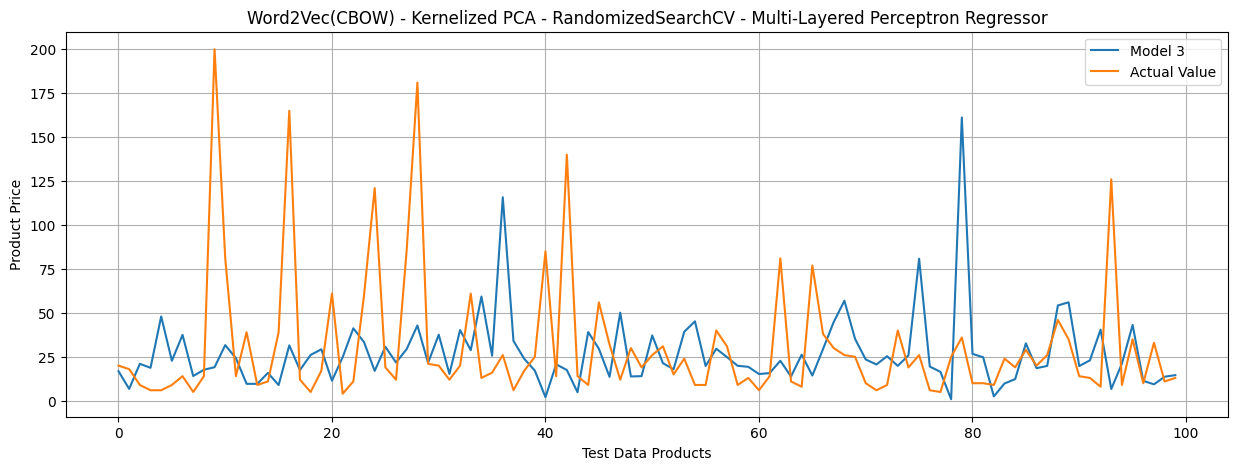

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.grid(True)
x= [i for i in range(100)]
plt.plot(x, y_pred_model3[:100], label='Model 3')
plt.plot(x, y_test[:100], label='Actual Value')

# Customize the plot
plt.title("Word2Vec(CBOW) - Kernelized PCA - RandomizedSearchCV - Multi-Layered Perceptron Regressor")
plt.xlabel("Test Data Products")
plt.ylabel("Product Price")
plt.legend()

# Display the plot
plt.show()
